In [1]:
from pyspark.sql import Column, DataFrame, SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import ArrayType, DoubleType, IntegerType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans, BisectingKMeansModel, BisectingKMeansSummary

from typing import List

import matplotlib.pyplot as plt

import numpy as np

In [2]:
DATA_PATH = '/media/maja/Samsung_T51/quasar'

In [3]:
spark: SparkSession = SparkSession.builder.appName('Spectra_Clustering') \
                      .master('local').getOrCreate()

In [4]:
df: DataFrame = spark.read.parquet(f'{DATA_PATH}/cleaned-spectra.parquet')

In [13]:
spectra_sample = df.head(10)
spectra_samples = []

for i in range(10):
    spectra_samples.append(spectra_sample[i].spectrum)

In [14]:
plot_spectra = []

for sample in spectra_samples:
    plot_spectra.append([x if x != None else 0.0 for x in sample])

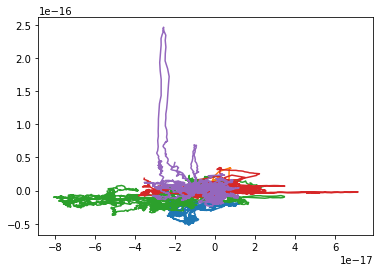

In [15]:
plt.plot(*plot_spectra)

## Preparation

### Rescale

In [27]:
@udf(DoubleType())
def max_in_array(x: ArrayType(DoubleType())) -> DoubleType():
    arr: List[DoubleType()] = [i for i in x if i != None]
    return max(arr) if arr else 0.0

@udf(DoubleType())
def min_in_array(x: ArrayType(DoubleType())) -> DoubleType():
    arr: List[DoubleType()] = [i for i in x if i != None]
    return min(arr) if arr else 0.0

spectra_min_max = df.select('spectrum') \
    .withColumn('max_spectrum', max_in_array(col('spectrum'))) \
    .withColumn('min_spectrum', min_in_array(col('spectrum')))

In [8]:
min_spectra_values = spectra_min_max.select('min_spectrum').collect()
max_spectra_values = spectra_min_max.select('max_spectrum').collect()

In [11]:
min_spectra_values = np.array(min_spectra_values)

In [20]:
np.percentile(min_spectra_values, 0.1)

-1.7350152909690405e-15

In [21]:
np.percentile(min_spectra_values, 99.9)

-4.322355765985711e-18

In [16]:
max_spectra_values = np.array(max_spectra_values)

In [22]:
np.percentile(max_spectra_values, 99.9)

1.3739437086449883e-15

In [23]:
np.percentile(max_spectra_values, 0.1)

4.482036389111347e-18

In [24]:
np.percentile(min_spectra_values, 50)

-2.5850769465020807e-17

In [25]:
np.percentile(max_spectra_values, 50)

4.8697077301730175e-17

### Rescale spectrum and continuum values

In [5]:
RESCALE: float = 1.0E17

In [6]:
@udf(ArrayType(DoubleType()))
def rescale(spectrum: ArrayType(DoubleType())) -> ArrayType(DoubleType()):
    return [x*RESCALE if x else 0.0 for x in spectrum]

In [29]:
spectra_rescaled: DataFrame = df\
    .withColumn('spectrum', rescale(col('spectrum')))\
    .withColumn('continuum', rescale(col('continuum')))

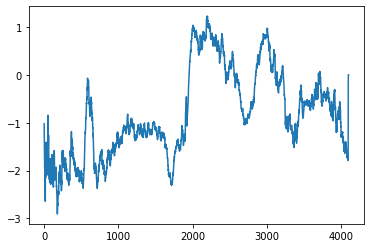

In [9]:
plt.plot(spectra_rescaled.head(1)[0].spectrum)

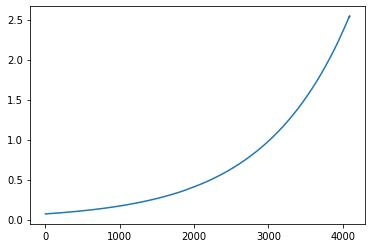

In [33]:
plt.plot(spectra_rescaled.head(1)[0].continuum)

In [ ]:
spectra_rescaled.write.parquet(f'{DATA_PATH}/spectra_rescaled.parquet')

### Spectrum vector feature

Explode an array column into many columns.

In [19]:
@udf(IntegerType())
def count_spectrum_elements(x: ArrayType(DoubleType())) -> IntegerType():
    return len(x)

spectra_rescaled.select('spectrum')\
.select(count_spectrum_elements(col('spectrum'))).describe().show()

+-------+---------------------------------+
|summary|count_spectrum_elements(spectrum)|
+-------+---------------------------------+
|  count|                           523673|
|   mean|                           4096.0|
| stddev|             4.505727490677490...|
|    min|                             4096|
|    max|                             4096|
+-------+---------------------------------+



In [10]:
SPECTRUM_SIZE: int = 4096
SPECTRUM_COLUMNS: List[Column] = list(map(lambda i: spectra_rescaled.spectrum[i], list(range(0, SPECTRUM_SIZE))))
SPECTRUM_COLUMN_NAMES: List[str] = list(map(lambda i: f'spectrum[{i}]', list(range(0, SPECTRUM_SIZE))))

In [11]:
spectra: DataFrame = spectra_rescaled.select(SPECTRUM_COLUMNS)

Construct a vector using VectorAssembler.

In [12]:
vecAssembler: VectorAssembler = VectorAssembler(outputCol='features')
vecAssembler.setInputCols(SPECTRUM_COLUMN_NAMES)

VectorAssembler_389d9f83a7c3

In [18]:
vectorized_spectra = vecAssembler.transform(spectra).select('features')

## Simple clustering

### Bisecting KMeans

In [22]:
bkm = BisectingKMeans(k=2)
bkm.setMaxIter(10)

BisectingKMeans_37adbfe82342

In [23]:
bkm_model = bkm.fit(vectorized_spectra)

Py4JJavaError: An error occurred while calling o8318.fit.
: java.lang.StackOverflowError
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1190)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1179)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1553)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1510)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1433)
